# load library

In [1]:
import os
import pandas as pd
import numpy as np
import datetime

import requests
from bs4 import BeautifulSoup
import time

#import sweetviz as sv
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

import statsmodels.formula.api as smf
from scipy import stats

# load data

## 대중교통 목적 통행량

In [2]:
filepath = './대중교통 목적통행량(일별)/'
filelist = os.listdir(filepath)

raw = pd.DataFrame()
for f in filelist:
    tmp = pd.read_excel(filepath + f, header=1)
    tmp = tmp.drop(0, axis=0)
    tmp = tmp.drop(['시도코드'] + [i for i in tmp.columns if '도착량' in i], axis=1)
    tmp.columns = list(tmp.columns[:5]) + [str(int(i.split('.')[-1])+3) + '_발생량' for i in tmp.columns[5:]]

    for c in tmp.columns[:3]:
        tmp[c] = tmp[c].map(lambda x: None if x == 0 else x)
        tmp[c] = tmp[c].fillna(method='ffill')
    tmp['일'] = tmp['일'].map(lambda x: datetime.datetime.strptime(x.split('(')[0], '%Y-%m-%d'))

    raw = pd.concat([raw, tmp], axis=0)
    print(f, '--->', raw.shape)
    
raw.head(3)

이용량 지표(목적통행량)_230408_230421.xlsx ---> (5367, 29)
이용량 지표(목적통행량)_230422_230505.xlsx ---> (10737, 29)
이용량 지표(목적통행량)_240127_240209.xlsx ---> (16111, 29)
이용량 지표(목적통행량)_240210_240223.xlsx ---> (21486, 29)
이용량 지표(목적통행량)_240224_240308.xlsx ---> (26854, 29)
이용량 지표(목적통행량)_240309_240322.xlsx ---> (32231, 29)
이용량 지표(목적통행량)_240323_240405.xlsx ---> (37614, 29)
이용량 지표(목적통행량)_240406_240419.xlsx ---> (42991, 29)
이용량 지표(목적통행량)_240420_240503.xlsx ---> (48362, 29)
이용량 지표(목적통행량)_240504_240517.xlsx ---> (53773, 29)
이용량 지표(목적통행량)_240518_240531.xlsx ---> (59206, 29)
이용량 지표(목적통행량)_240601_240614.xlsx ---> (64637, 29)
이용량 지표(목적통행량)_240615_240628.xlsx ---> (70066, 29)
이용량 지표(목적통행량)_240629_240712.xlsx ---> (75495, 29)
이용량 지표(목적통행량)_240713_240726.xlsx ---> (80929, 

,시도,시군구,일,이용자유형,발생량,4_발생량,5_발생량,6_발생량,7_발생량,8_발생량,...,18_발생량,19_발생량,20_발생량,21_발생량,22_발생량,23_발생량,24_발생량,25_발생량,26_발생량,27_발생량
1,서울특별시,강남구,2023-04-08,경로,54828,49,868,1946,1502,2208,...,3023,2472,2062,1324,886,216,9,3,5,1
2,서울특별시,강남구,2023-04-08,국가유공자,695,1,11,17,14,25,...,39,41,36,17,13,7,0,1,1,0
3,서울특별시,강남구,2023-04-08,어린이,7809,0,3,8,16,144,...,542,362,242,182,110,18,1,0,0,0


In [3]:
tab = pd.DataFrame(raw.groupby(['시도', '시군구', '일'])['발생량'].sum())
tab = tab.sort_index()
tab = tab.reset_index()

tab.head(3)

,시도,시군구,일,발생량
0,광주광역시,광산구,2022-01-01,26473
1,광주광역시,광산구,2022-01-02,26698
2,광주광역시,광산구,2022-01-03,56775


In [4]:
for i in ['일반인', '어린이', '청소년', '경로', '장애인', '국가유공자', '외국인']:
    print(i, end=' ')
    tab = pd.merge(tab, 
                   raw.loc[raw['이용자유형'] == i, 
                           ['시도', '시군구', '일', '발생량']].rename(columns={'발생량':i}), 
                   on=['시도', '시군구', '일'], 
                   how='left')

일반인 어린이 청소년 경로 장애인 국가유공자 외국인 

In [5]:
for i in raw.columns[5:]:
    print(i, end=' ')
    tab = pd.merge(tab, 
                   raw.loc[:, ['시도', '시군구', '일', i]].groupby(['시도', '시군구', '일'])[i].sum(), 
                   on=['시도', '시군구', '일'], 
                   how='left')

4_발생량 5_발생량 6_발생량 7_발생량 8_발생량 9_발생량 10_발생량 11_발생량 12_발생량 13_발생량 14_발생량 15_발생량 16_발생량 17_발생량 18_발생량 19_발생량 20_발생량 21_발생량 22_발생량 23_발생량 24_발생량 25_발생량 26_발생량 27_발생량 

In [6]:
tab.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56369 entries, 0 to 56368
Data columns (total 35 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   시도      56369 non-null  object        
 1   시군구     56369 non-null  object        
 2   일       56369 non-null  datetime64[ns]
 3   발생량     56369 non-null  int64         
 4   일반인     56352 non-null  float64       
 5   어린이     56260 non-null  float64       
 6   청소년     56240 non-null  float64       
 7   경로      49471 non-null  float64       
 8   장애인     49284 non-null  float64       
 9   국가유공자   49627 non-null  float64       
 10  외국인     27558 non-null  float64       
 11  4_발생량   56369 non-null  int64         
 12  5_발생량   56369 non-null  int64         
 13  6_발생량   56369 non-null  int64         
 14  7_발생량   56369 non-null  int64         
 15  8_발생량   56369 non-null  int64         
 16  9_발생량   56369 non-null  int64         
 17  10_발생량  56369 non-null  int64         
 18  11_발생량

In [7]:
tab.groupby(['시도', '시군구'])['발생량'].count() # 확인

시도     시군구 
광주광역시  광산구     952
       남구      952
       동구      952
       북구      952
       서구      952
대구광역시  군위군     201
       남구      952
       달서구     952
       달성군     952
       동구      952
       북구      952
       서구      952
       수성구     952
       중구      952
대전광역시  대덕구     952
       동구      952
       서구      952
       유성구     952
       중구      952
부산광역시  강서구     952
       금정구     952
       기장군     952
       남구      952
       동구      952
       동래구     952
       부산진구    952
       북구      952
       사상구     952
       사하구     952
       서구      952
       수영구     952
       연제구     952
       영도구     952
       중구      952
       해운대구    952
서울특별시  강남구     952
       강동구     952
       강북구     952
       강서구     952
       관악구     952
       광진구     952
       구로구     952
       금천구     952
       노원구     952
       도봉구     952
       동대문구    952
       동작구     952
       마포구     952
       서대문구    952
       서초구     952
       성동구     952
       성북구     952


In [8]:
tab.to_excel('./rawdata_세부 목적통행량.xlsx', index=False)
tab.to_pickle('./rawdata_세부 목적통행량.pickle')

## 주민등록 인구

In [2]:
raw = pd.read_pickle('./rawdata_세부 목적통행량.pickle')
raw = raw[['시도', '시군구', '일', '발생량']].copy()
raw = raw.rename(columns={'발생량':'목적통행량'})

raw.head(3)

,시도,시군구,일,목적통행량
0,광주광역시,광산구,2022-01-01,26473
1,광주광역시,광산구,2022-01-02,26698
2,광주광역시,광산구,2022-01-03,56775


In [3]:
filepath = './주민등록인구/'
filelist = os.listdir(filepath)

raw_pop = pd.DataFrame()
for f in filelist:
    print(f)
    tmp = pd.read_csv(filepath + f, encoding='euc-kr')
    tmp = tmp.drop(0, axis=0)
    tmp2 = tmp[['행정구역'] + [i for i in tmp.columns if '총인구수' in i]].copy()

    for c in tmp2.columns[1:]:
        t = tmp2[['행정구역', c]].copy()
        t['시도'] = t['행정구역'].map(lambda x: x.split(' ')[0])
        t['시군구'] = t['행정구역'].map(lambda x: x.split(' ')[1])
        t['일'] = datetime.datetime.strptime(c.replace('_총인구수', ''), '%Y년%m월')
        t = t.rename(columns={c:'총 인구 수'})

        raw_pop = pd.concat([raw_pop, t[['시도', '시군구', '일', '총 인구 수']]], axis=0)
        print(c, '--->', raw_pop.shape)

raw_pop.head(3)

202201_202408_주민등록인구및세대현황_광주.csv
2022년01월_총인구수 ---> (5, 4)
2022년02월_총인구수 ---> (10, 4)
2022년03월_총인구수 ---> (15, 4)
2022년04월_총인구수 ---> (20, 4)
2022년05월_총인구수 ---> (25, 4)
2022년06월_총인구수 ---> (30, 4)
2022년07월_총인구수 ---> (35, 4)
2022년08월_총인구수 ---> (40, 4)
2022년09월_총인구수 ---> (45, 4)
2022년10월_총인구수 ---> (50, 4)
2022년11월_총인구수 ---> (55, 4)
2022년12월_총인구수 ---> (60, 4)
2023년01월_총인구수 ---> (65, 4)
2023년02월_총인구수 ---> (70, 4)
2023년03월_총인구수 ---> (75, 4)
2023년04월_총인구수 ---> (80, 4)
2023년05월_총인구수 ---> (85, 4)
2023년06월_총인구수 ---> (90, 4)
2023년07월_총인구수 ---> (95, 4)
2023년08월_총인구수 ---> (100, 4)
2023년09월_총인구수 ---> (105, 4)
2023년10월_총인구수 ---> (110, 4)
2023년11월_총인구수 ---> (115, 4)
2023년12월_총인구수 ---> (120, 4)
2024년01월_총인구수 ---> (125, 4)
2024년02월_총인구수 ---> (130, 4)
2024년03월_총인구수 ---> (135, 4)
2024년04월_총인구수 ---> (140, 4)
2024년05월_총인구수 ---> (145, 4)
2024년06월_총인구수 ---> (150, 4)
2024년07월_총인구수 ---> (155, 4)
2024년08월_총인구수 ---> (160, 4)
202201_202408_주민등록인구및세대현황_대구.csv
2022년01월_총인구수 ---> (169, 4)
2022년02월_총인구수 ---> (178, 4)
20

,시도,시군구,일,총 인구 수
1,광주광역시,동구,2022-01-01,"103,466"
2,광주광역시,서구,2022-01-01,"291,235"
3,광주광역시,남구,2022-01-01,"215,739"


In [4]:
df = pd.merge(raw, raw_pop, on=['시도', '시군구', '일'], how='left')
df['총 인구 수'] = df['총 인구 수'].fillna(method='ffill')
df['총 인구 수'] = df['총 인구 수'].map(lambda x: int(x.replace(',', '')))
df['인구당 목적통행량'] = round(df['목적통행량'] / (df['총 인구 수'] / 1000), 1) # 천명 단위

df.sample(3)

,시도,시군구,일,목적통행량,총 인구 수,인구당 목적통행량
26601,부산광역시,사하구,2023-11-28,157178,298339,526.8
6946,대구광역시,달성군,2022-03-23,37978,262372,144.7
30800,부산광역시,중구,2022-05-16,95236,40537,2349.4


## 방문객 수

In [5]:
filepath = './방문객 수/'
filelist = os.listdir(filepath)

raw_vis = pd.DataFrame()
for f in filelist:
    tmp = pd.read_csv(filepath + f, encoding='euc-kr')
    
    tmp2 = tmp.loc[tmp['방문자 구분'] == '전체방문자(a+b+c)'].copy()
    tmp2 = tmp2.rename(columns={'기준년월':'일', '광역지자체':'시도'})
    tmp2['일'] = tmp2['일'].map(lambda x: datetime.datetime.strptime(str(x), '%Y%m%d'))
    
    raw_vis = pd.concat([raw_vis, tmp2[['시도', '일', '방문자 수']]], axis=0)
    print(f, '--->', raw_vis.shape)

raw_vis.head(3)

방문자 수 추이_광주_2201.csv ---> (31, 3)
방문자 수 추이_광주_2202.csv ---> (59, 3)
방문자 수 추이_광주_2203.csv ---> (90, 3)
방문자 수 추이_광주_2204.csv ---> (120, 3)
방문자 수 추이_광주_2205.csv ---> (151, 3)
방문자 수 추이_광주_2206.csv ---> (181, 3)
방문자 수 추이_광주_2207.csv ---> (212, 3)
방문자 수 추이_광주_2208.csv ---> (243, 3)
방문자 수 추이_광주_2209.csv ---> (273, 3)
방문자 수 추이_광주_2210.csv ---> (304, 3)
방문자 수 추이_광주_2211.csv ---> (334, 3)
방문자 수 추이_광주_2212.csv ---> (365, 3)
방문자 수 추이_광주_2301.csv ---> (396, 3)
방문자 수 추이_광주_2302.csv ---> (424, 3)
방문자 수 추이_광주_2303.csv ---> (455, 3)
방문자 수 추이_광주_2304.csv ---> (485, 3)
방문자 수 추이_광주_2305.csv ---> (516, 3)
방문자 수 추이_광주_2306.csv ---> (546, 3)
방문자 수 추이_광주_2307.csv ---> (577, 3)
방문자 수 추이_광주_2308.csv ---> (608, 3)
방문자 수 추이_광주_2309.csv ---> (638, 3)
방문자 수 추이_광주_2310.csv ---> 

,시도,일,방문자 수
124,광주광역시,2022-01-01,777793.0
125,광주광역시,2022-01-02,779073.0
126,광주광역시,2022-01-03,826813.0


In [6]:
df = pd.merge(df, raw_vis, on=['시도', '일'], how='left')

df.sample(3)

,시도,시군구,일,목적통행량,총 인구 수,인구당 목적통행량,방문자 수
35852,서울특별시,강서구,2023-03-04,262746,568287,462.3,6427894.0
30620,부산광역시,영도구,2024-06-26,52989,105434,502.6,1890167.0
52010,서울특별시,용산구,2023-02-06,242764,218175,1112.7,6337155.0


## 서울 자동차 통행량

In [7]:
filepath = './서울 자동차 통행량/'
filelist = os.listdir(filepath)

raw_car = pd.DataFrame()
for f in filelist:
    tmp = pd.read_csv(filepath + f)
    tmp = tmp.rename(columns={'기준일':'일', '차량수량':'차량통행량'})
    tmp['일'] = tmp['일'].map(lambda x: datetime.datetime.strptime(str(x), '%Y%m%d'))
    
    tmp2 = pd.DataFrame(tmp.groupby(['일'])['차량통행량'].sum())
    tmp2['시도'] = '서울특별시'
    tmp2 = tmp2.reset_index()  
    
    raw_car = pd.concat([raw_car, tmp2], axis=0)
    print(f, '--->', raw_car.shape)

raw_car.head(3)

TB_BDS_IDX_PASNG_202301.csv ---> (31, 3)
TB_BDS_IDX_PASNG_202302.csv ---> (59, 3)
TB_BDS_IDX_PASNG_202303.csv ---> (90, 3)
TB_BDS_IDX_PASNG_202304.csv ---> (120, 3)
TB_BDS_IDX_PASNG_202305.csv ---> (151, 3)
TB_BDS_IDX_PASNG_202306.csv ---> (181, 3)
TB_BDS_IDX_PASNG_202307.csv ---> (212, 3)
TB_BDS_IDX_PASNG_202308.csv ---> (243, 3)
TB_BDS_IDX_PASNG_202309.csv ---> (273, 3)
TB_BDS_IDX_PASNG_202310.csv ---> (304, 3)
TB_BDS_IDX_PASNG_202311.csv ---> (334, 3)
TB_BDS_IDX_PASNG_202312.csv ---> (365, 3)
TB_BDS_IDX_PASNG_202401.csv ---> (396, 3)
TB_BDS_IDX_PASNG_202402.csv ---> (411, 3)
TB_BDS_IDX_PASNG_202403.csv ---> (442, 3)
TB_BDS_IDX_PASNG_202404.csv ---> (472, 3)
TB_BDS_IDX_PASNG_202405.csv ---> (503, 3)
TB_BDS_IDX_PASNG_202406.csv ---> (533, 3)
TB_BDS_IDX_PASNG_202407.csv ---> (564, 3)


,일,차량통행량,시도
0,2023-01-01,478022,서울특별시
1,2023-01-02,675992,서울특별시
2,2023-01-03,733454,서울특별시


In [8]:
df = pd.merge(df, raw_car, on=['시도', '일'], how='left')

df.sample(3)

,시도,시군구,일,목적통행량,총 인구 수,인구당 목적통행량,방문자 수,차량통행량
30658,부산광역시,영도구,2024-08-03,36078,104914,343.9,1855105.0,NaN
23315,부산광역시,부산진구,2022-09-24,219049,351125,623.8,2062646.0,NaN
52146,서울특별시,용산구,2023-06-22,295618,217288,1360.5,6456648.0,794265.0


## 서울 따릉이 이용량

In [9]:
filepath = './서울 따릉이/'
filelist = os.listdir(filepath)

raw_bic = pd.DataFrame()
for f in filelist:
    tmp = pd.read_csv(filepath + f)
    tmp2 = tmp.loc[tmp['제목'] == '따릉이'].copy()
    tmp2 = tmp2.rename(columns={'기준일':'일', '서울_수':'따릉이 이용량'})
    tmp2['일'] = tmp2['일'].map(lambda x: datetime.datetime.strptime(str(x), '%Y%m%d'))
    tmp2['시도'] = '서울특별시'
    
    raw_bic = pd.concat([raw_bic, tmp2[['시도', '일', '따릉이 이용량']]], axis=0)
    print(f, '--->', raw_bic.shape)

raw_bic.head(3)

TB_BDS_PBTRNSP_USE_INFO_202301.csv ---> (31, 3)
TB_BDS_PBTRNSP_USE_INFO_202302.csv ---> (59, 3)
TB_BDS_PBTRNSP_USE_INFO_202303.csv ---> (90, 3)
TB_BDS_PBTRNSP_USE_INFO_202304.csv ---> (120, 3)
TB_BDS_PBTRNSP_USE_INFO_202305.csv ---> (151, 3)
TB_BDS_PBTRNSP_USE_INFO_202306.csv ---> (181, 3)
TB_BDS_PBTRNSP_USE_INFO_202307.csv ---> (212, 3)
TB_BDS_PBTRNSP_USE_INFO_202308.csv ---> (243, 3)
TB_BDS_PBTRNSP_USE_INFO_202309.csv ---> (273, 3)
TB_BDS_PBTRNSP_USE_INFO_202310.csv ---> (304, 3)
TB_BDS_PBTRNSP_USE_INFO_202311.csv ---> (334, 3)
TB_BDS_PBTRNSP_USE_INFO_202312.csv ---> (365, 3)
TB_BDS_PBTRNSP_USE_INFO_202401.csv ---> (396, 3)
TB_BDS_PBTRNSP_USE_INFO_202402.csv ---> (411, 3)
TB_BDS_PBTRNSP_USE_INFO_202403.csv ---> (442, 3)
TB_BDS_PBTRNSP_USE_INFO_202404.csv ---> (472, 3)
TB_BDS_PBTRNSP_USE_INFO_202405.csv ---> (503, 3)
TB_BDS_PBTRNSP_USE_INFO_202406.csv ---> (533, 3)
TB_BDS_PBTRNSP_USE_INFO_202407.csv ---> (564, 3)


,시도,일,따릉이 이용량
0,서울특별시,2023-01-01,792143
5,서울특별시,2023-01-02,842812
10,서울특별시,2023-01-03,612788


In [10]:
df = pd.merge(df, raw_bic, on=['시도', '일'], how='left')

df.sample(3)

,시도,시군구,일,목적통행량,총 인구 수,인구당 목적통행량,방문자 수,차량통행량,따릉이 이용량
55514,서울특별시,중랑구,2022-04-08,195817,388941,503.5,6324618.0,NaN,NaN
7092,대구광역시,달성군,2022-08-16,36819,263175,139.9,1395534.0,NaN,NaN
39538,서울특별시,금천구,2022-11-02,213363,229890,928.1,6477737.0,NaN,NaN


## 대중교통 평균통행거리(1km)

In [11]:
raw_dis = pd.read_excel('./대중교통 평균통행거리/평균통행거리_2023.xlsx')
raw_dis['시도'] = raw_dis['시도'].map(lambda x: None if x == 0 else x)
raw_dis['시도'] = raw_dis['시도'].fillna(method='ffill')
raw_dis = raw_dis.rename(columns={'합계':'평균통행거리(km)'})

raw_dis.head(3)

,시도코드,시도,시군구,년,평균통행거리(km)
0,11,서울특별시,강남구,2023,12.38
1,0,서울특별시,강동구,2023,10.27
2,0,서울특별시,강북구,2023,8.71


In [12]:
df = pd.merge(df, raw_dis[['시도', '시군구', '평균통행거리(km)']], on=['시도', '시군구'], how='left')
df = df.reset_index(drop=True)

df.sample(3)

,시도,시군구,일,목적통행량,총 인구 수,인구당 목적통행량,방문자 수,차량통행량,따릉이 이용량,평균통행거리(km)
51378,서울특별시,영등포구,2023-12-23,326626,374794,871.5,NaN,633710.0,771493.0,10.84
11319,대구광역시,수성구,2023-10-09,68245,406802,167.8,1393007.0,NaN,NaN,0.06
10506,대구광역시,서구,2024-02-25,31999,164734,194.2,1422352.0,NaN,NaN,0.05


# pre-processing

In [13]:
treat_date = datetime.datetime(2024,1,27,0,0)
end_date = datetime.datetime(2024,8,1,0,0)

df = df.loc[df['일'] < end_date].copy()
df['treated'] = df['시도'].map(lambda x: 1 if x == '서울특별시' else 0)
df['post'] = df['일'].map(lambda x: 1 if x >= treat_date else 0)
df['w'] = df['treated'] * df['post']

df['주차'] = df['일'].map(lambda x: str(x.year) + str(x.strftime('%V')))
df['일자'] = df['일'].map(lambda x: x.date())
df = df.reindex(columns=[
    '일자', '주차', '시도', '시군구', 
    '총 인구 수', '방문자 수', '차량통행량', '따릉이 이용량', '평균통행거리(km)', 
    '목적통행량','인구당 목적통행량', 'treated', 'post', 'w'])

df.head(3)

,일자,주차,시도,시군구,총 인구 수,방문자 수,차량통행량,따릉이 이용량,평균통행거리(km),목적통행량,인구당 목적통행량,treated,post,w
0,2022-01-01,202252,광주광역시,광산구,404319,777793.0,NaN,NaN,6.4,26473,65.5,0,0,0
1,2022-01-02,202252,광주광역시,광산구,404319,779073.0,NaN,NaN,6.4,26698,66.0,0,0,0
2,2022-01-03,202201,광주광역시,광산구,404319,826813.0,NaN,NaN,6.4,56775,140.4,0,0,0


In [14]:
df.to_excel('./rawdata.xlsx', index=False)
df.to_pickle('./rawdata.pickle')

# EDA

In [15]:
df = pd.read_pickle('./rawdata.pickle')

df.head(3)

,일자,주차,시도,시군구,총 인구 수,방문자 수,차량통행량,따릉이 이용량,평균통행거리(km),목적통행량,인구당 목적통행량,treated,post,w
0,2022-01-01,202252,광주광역시,광산구,404319,777793.0,NaN,NaN,6.4,26473,65.5,0,0,0
1,2022-01-02,202252,광주광역시,광산구,404319,779073.0,NaN,NaN,6.4,26698,66.0,0,0,0
2,2022-01-03,202201,광주광역시,광산구,404319,826813.0,NaN,NaN,6.4,56775,140.4,0,0,0


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 55829 entries, 0 to 56359
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   일자          55829 non-null  object 
 1   주차          55829 non-null  object 
 2   시도          55829 non-null  object 
 3   시군구         55829 non-null  object 
 4   총 인구 수      55829 non-null  int64  
 5   방문자 수       48979 non-null  float64
 6   차량통행량       14100 non-null  float64
 7   따릉이 이용량     14100 non-null  float64
 8   평균통행거리(km)  55829 non-null  float64
 9   목적통행량       55829 non-null  int64  
 10  인구당 목적통행량   55829 non-null  float64
 11  treated     55829 non-null  int64  
 12  post        55829 non-null  int64  
 13  w           55829 non-null  int64  
dtypes: float64(5), int64(5), object(4)
memory usage: 6.4+ MB


In [19]:
tmp = pd.DataFrame(df.groupby('시도')['시군구'].unique())
tmp['len'] = tmp['시군구'].map(len)
tmp

,시군구,len
시도,,
광주광역시,"[광산구, 남구, 동구, 북구, 서구]",5
대구광역시,"[군위군, 남구, 달서구, 달성군, 동구, 북구, 서구, 수성구, 중구]",9
대전광역시,"[대덕구, 동구, 서구, 유성구, 중구]",5
부산광역시,"[강서구, 금정구, 기장군, 남구, 동구, 동래구, 부산진구, 북구, 사상구, 사하...",16
서울특별시,"[강남구, 강동구, 강북구, 강서구, 관악구, 광진구, 구로구, 금천구, 노원구, ...",25


In [20]:
#sv.analyze(df).show_html('./EDA.html')

In [21]:
# sv.compare(df.loc[df['region'] == '서울특별시'], 
#            df.loc[df['region'] != '서울특별시']).show_html('./data/compared_EDA.html')

In [22]:
df.groupby('시도')[df.columns[4:-3]].mean().round() # 그룹별 통계량

,총 인구 수,방문자 수,차량통행량,따릉이 이용량,평균통행거리(km),목적통행량,인구당 목적통행량
시도,,,,,,,
광주광역시,285346.0,879417.0,NaN,NaN,5.0,52584.0,217.0
대구광역시,290129.0,1458638.0,NaN,NaN,0.0,83515.0,370.0
대전광역시,289067.0,945075.0,NaN,NaN,7.0,70666.0,249.0
부산광역시,206988.0,1897298.0,NaN,NaN,5.0,105272.0,606.0
서울특별시,377192.0,6238517.0,694184.0,733658.0,11.0,298295.0,932.0


In [23]:
# 엑셀 피벗 차트용
df['목적통행량(천)'] = df['목적통행량']//1000
df['방문자 수(만)'] = df['방문자 수']//10000
df['차량통행량(천)'] = df['차량통행량']//1000
df['따릉이 이용량(천)'] = df['따릉이 이용량']//1000

df.sample(3)

,일자,주차,시도,시군구,총 인구 수,방문자 수,차량통행량,따릉이 이용량,평균통행거리(km),목적통행량,인구당 목적통행량,treated,post,w,목적통행량(천),방문자 수(만),차량통행량(천),따릉이 이용량(천)
47435,2023-08-10,202332,서울특별시,성동구,278750,5378920.0,613284.0,666739.0,10.00,196260,704.1,1,0,0,196,537.0,613.0,666.0
22199,2022-04-13,202215,부산광역시,동래구,273976,1723723.0,NaN,NaN,3.41,125978,459.8,0,0,0,125,172.0,NaN,NaN
4622,2024-03-25,202413,광주광역시,서구,282898,878141.0,NaN,NaN,5.06,65747,232.4,0,1,0,65,87.0,NaN,NaN


In [24]:
df.to_excel('./rawdata_피벗 차트.xlsx', index=False)

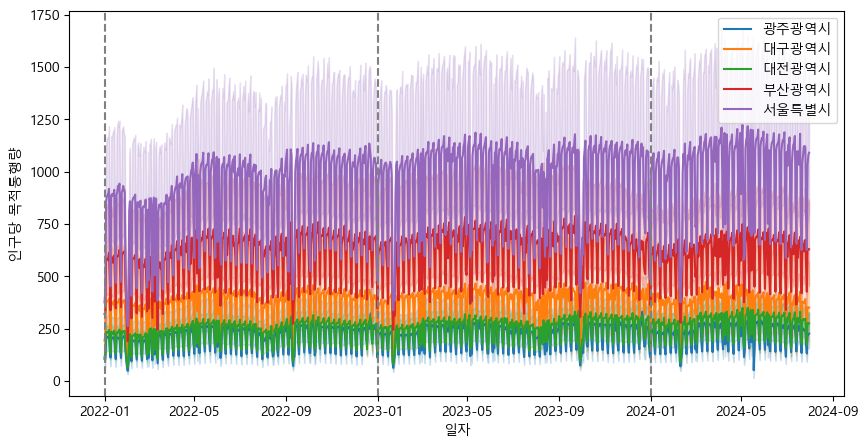

In [25]:
plt.figure(figsize=(10, 5))
sns.lineplot(data=df, x='일자', y='인구당 목적통행량', hue='시도')
for y in range(2022, 2025):
    plt.axvline(datetime.datetime(y,1,1,0,0), color='gray', linestyle='--')
plt.legend(bbox_to_anchor=(1,1))

# T-test
- data reload

In [8]:
raw = pd.read_pickle('./rawdata.pickle')

df = raw.loc[(raw['시도'] == '서울특별시') & 
             (raw['일자'].map(lambda x: x.year) >= 2023) &
             (raw['일자'].map(lambda x: x.month) >= 2) &
             (raw['일자'].map(lambda x: x.month) <= 6),
             ['시도', '시군구', '일자', '목적통행량']].copy()
df['group'] = df['일자'].map(lambda x: 'before' if x.year == 2023 else 'after')

df.head(3)

,시도,시군구,일자,목적통행량,group
32965,서울특별시,강남구,2023-02-01,933965,before
32966,서울특별시,강남구,2023-02-02,945194,before
32967,서울특별시,강남구,2023-02-03,973296,before


In [13]:
res = pd.DataFrame(df.loc[df['group'] == 'before'].groupby('시군구')['목적통행량'].mean())
res.columns = ['before']
res['after'] = df.loc[df['group'] == 'after'].groupby('시군구')['목적통행량'].mean()
res = res.round()
res.loc['total'] = res.sum(axis=0)
res

,before,after
시군구,,
강남구,798999.0,796730.0
강동구,193138.0,195287.0
강북구,195598.0,194629.0
강서구,338664.0,340534.0
관악구,331885.0,329066.0
광진구,253640.0,255132.0
구로구,302309.0,301552.0
금천구,179861.0,175198.0
노원구,269566.0,275182.0


In [27]:
t_stat, p_value = stats.ttest_rel(res['before'], res['after'])

print(f"T-statistic: {t_stat.round(4)}")
print(f"P-value: {p_value.round(4)}")
print('----------')

if p_value < 0.05:
    print("기후동행카드 도입에 따른 목적통행량에 유의미한 차이가 있습니다.")
    if t_stat > 0:
        print("도입 이전(2023년) 대비 도입 이후(2024년) 목적통행량이 감소하였습니다.")
    else:
        print("도입 이전(2023년) 대비 도입 이후(2024년) 목적통행량이 증가하였습니다.")
else:
    print("기후동행카드 도입에 따른 목적통행량에 유의미한 차이가 없습니다.")
    
print('----------')
print('서울시 월평균 목적통행량 변화:')
print(res.sum())
print('전년 동기 목적통행량 증가량 :', res.sum()['after'] - res.sum()['before'])

T-statistic: -2.7934
P-value: 0.0101
----------
기후동행카드 도입에 따른 목적통행량에 유의미한 차이가 있습니다.
도입 이전(2023년) 대비 도입 이후(2024년) 목적통행량이 증가하였습니다.
----------
서울시 월평균 목적통행량 변화:
before    7815600.0
after     7879908.0
dtype: float64
전년 동기 목적통행량 증가량 : 64308.0


# causal inference

## did

In [3]:
raw = pd.read_pickle('./rawdata.pickle')

df = raw.loc[raw['시도'].map(lambda x: x in ['서울특별시', '부산광역시']),
             ['일자', '시도', '시군구', '인구당 목적통행량', 'treated', 'post', 'w']].copy()
df['일자'] = df['일자'].map(lambda x: datetime.datetime.combine(x, datetime.datetime.min.time()))
df = df.reset_index(drop=True)

df.head(3)

,일자,시도,시군구,인구당 목적통행량,treated,post,w
0,2022-01-01,부산광역시,강서구,140.1,0,0,0
1,2022-01-02,부산광역시,강서구,149.9,0,0,0
2,2022-01-03,부산광역시,강서구,275.6,0,0,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38663 entries, 0 to 38662
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   일자         38663 non-null  datetime64[ns]
 1   시도         38663 non-null  object        
 2   시군구        38663 non-null  object        
 3   인구당 목적통행량  38663 non-null  float64       
 4   treated    38663 non-null  int64         
 5   post       38663 non-null  int64         
 6   w          38663 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(2)
memory usage: 2.1+ MB


In [5]:
x = '일자'
y = '인구당 목적통행량'

df_did = (df.groupby(["treated", "post"])
            .agg({y:"mean", x: ["min", "max"]}))

df_did['인구당 목적통행량'] = df_did['인구당 목적통행량'].round(1)
df_did

인구당 목적통행량         일자           
                  mean        min        max
treated post                                
0       0        606.7 2022-01-01 2024-01-26
        1        603.8 2024-01-27 2024-07-31
1       0        916.2 2022-01-01 2024-01-26
        1        994.2 2024-01-27 2024-07-31

In [6]:
y0_est = (df_did.loc[1].loc[0, y] # treated baseline(treat 1 / post 0)
          + df_did.loc[0].diff().loc[1,y]) # control 추세

att = df_did.loc[1].loc[1, y] - y0_est
att

mean    80.9
dtype: object

In [7]:
# 고정효과 회귀
df = df.rename(columns={'인구당 목적통행량':'y'})

m = smf.ols('y ~ treated:post + C(시도) + C(시군구) + C(일자)', data=df).fit()
# m = smf.ols('y ~ treated:post + C(시도) + C(시군구) + C(일자)', data=df).fit(
#     cov_type='cluster', cov_kwds={'groups': df['시도']})

m.params['treated:post'] # 인과 효과 추정량(시군구, 일 단위)

80.933543691447

In [8]:
m.conf_int().loc['treated:post'] # 신뢰구간

0    70.857382
1    91.009705
Name: treated:post, dtype: float64